# Principal Component Analysis

This section covers our first unsupervised learning algorithm. Principal Component Analysis (PCA) is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, noise filtering, feature extraction and engineering, and much more.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Introducing Principal Component Analysis

Let's start with an example:

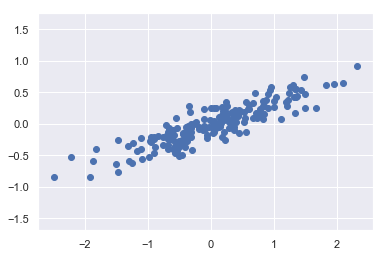

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

While linear regression would try to _predit_ the value of y from x, PCA tries to learn about the _relationship_ between x and y. In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


Let's visualize them as vectors on our graph:

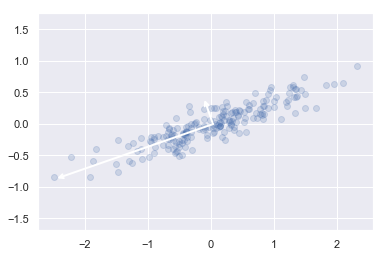

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


We have now reduced our dataset to a single component / dimension. Here is how it looks like:

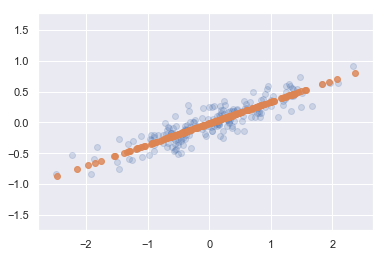

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

As we can see, the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. 

### PCA for visualization: Hand-written digits

Let's use our usual hand-written digits dataset for a second example:

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [10]:
# reduce dimensions from 64 (8 pixels x 8 pixels) to 2
pca = PCA(2)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


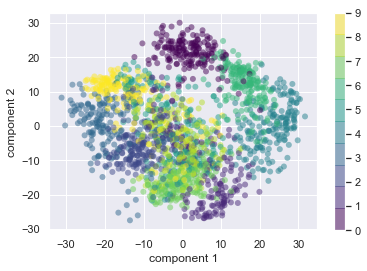

In [11]:
# plotting the first two principal dimensions
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### What do the components mean?

To understand what components _mean_, we can start by thinking of them as combinations of basis vectors. For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector x:

<code>x=[x1,x2,x3⋯x64]</code>

In terms of pixels, we can describe each digit/image as this:  

<code>image(x)=x1⋅(pixel 1)+x2⋅(pixel 2)+x3⋅(pixel 3)⋯x64⋅(pixel 64)</code>  

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like:

<code>image(x)=mean+x1⋅(basis 1)+x2⋅(basis 2)+x3⋅(basis 3)⋯</code>

PCA can be thought of as a **process of choosing optimal basis functions**, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.

This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

Choosing the optimal number of components can be determined by looking at the _cumulative explained variance ratio as a function of the number of components_:

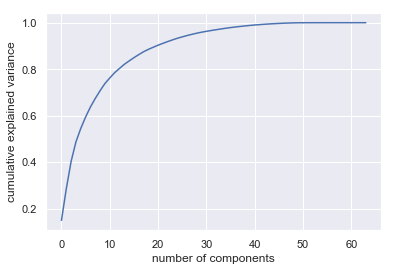

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that for example the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

### PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data. 

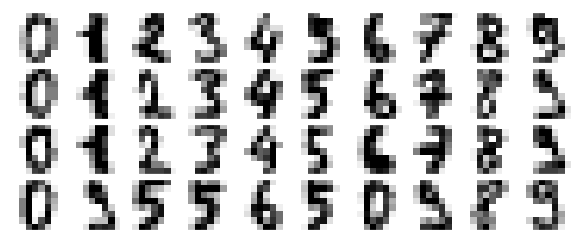

In [13]:
# noise-free data
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

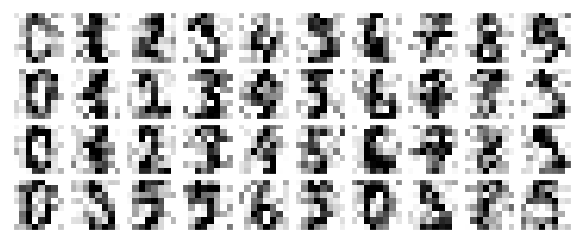

In [14]:
# adding noise
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [15]:
# preserving 50% of the variance
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

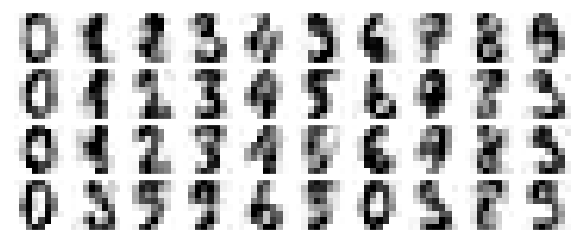

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

### Example: Eigenfaces

Let's look into more detail at how we use PCA as a feature selector for facial recognition:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder' 'Junichiro Koizumi'
 'Tony Blair']
(919, 62, 47)


Because this is a large dataset, we will use <code>RandomizedPCA</code>—it contains a randomized method to approximate the first _N_ principal components much more quickly than the standard PCA estimator.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors," so these types of images are often called "eigenfaces").

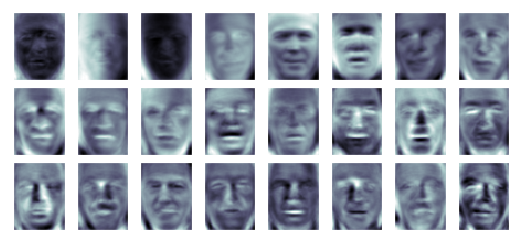

In [21]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

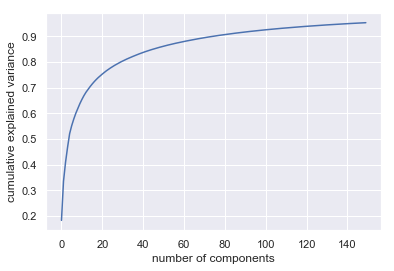

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Let's compare the input images with the images reconstructed from these 150 components, which according to our graph should retain roughly 95% of the variance:

In [23]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

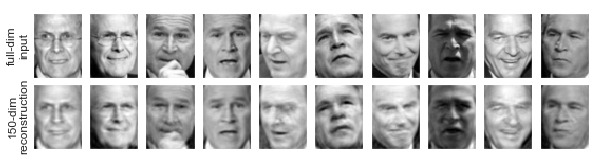

In [24]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');